In [1]:
import utilities as utils

/home/drake/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



    Last Execution: 2022-04-27 05:19:35.114678
    python:	3.8.5

    	fastai:		2.5.6
    	matplotlib:	3.5.1
    	numpy:		1.19.5
    	pandas:		1.4.1
    	seaborn:	0.11.2
    	sklearn:	1.0.2
    	torch:		1.11.0+cu102
    	yellowbrick:	1.4
    	imblearn:	0.9.0
    


In [2]:
data_path_1: str = './synthetic/'   
data_path_2: str = '../../../Data/phase2/'   

data_set_1: list = [ 'gan_application_30000.csv', 
                     'gan_application_upsample_to_majority.csv',
                     'gan_traffic_30_20_10.csv',
                     'gan_traffic_upsample_to_majority.csv']

data_set_2: list = [ 'Traffic_type_test.csv', 'Application_type_test.csv' ] 


file_path_1       = utils.get_file_path(data_path_1)
file_path_2       = utils.get_file_path(data_path_2)
file_set_1 : list = list(map(file_path_1, data_set_1))
file_set_2 : list = list(map(file_path_2, data_set_2))

file_set : list   = file_set_1 + file_set_2 
data_set   : list = data_set_1 + data_set_2 
current_job: int  = 0

utils.data_set = data_set
utils.file_set = file_set

In [3]:
print(f'We will be using {len(file_set)} files:')
utils.pretty(file_set)

We will be using 6 files:
[   './synthetic/gan_application_30000.csv',
    './synthetic/gan_application_upsample_to_majority.csv',
    './synthetic/gan_traffic_30_20_10.csv',
    './synthetic/gan_traffic_upsample_to_majority.csv',
    '../../../Data/phase2/Traffic_type_test.csv',
    '../../../Data/phase2/Application_type_test.csv']


In [4]:
gan_balanced_application_dataset_labels_30_30_30 = utils.examine_dataset(1)
gan_balanced_application_dataset_labels_equal = utils.examine_dataset(2)
gan_balanced_traffic_labels_dataset_30_20_10 = utils.examine_dataset(3)
gan_balanced_traffic_labels_dataset_equal = utils.examine_dataset(4)
baseline_traffic_test = utils.examine_dataset(5)
baseline_application_test = utils.examine_dataset(6)

Dataset 1/6: We now look at ./synthetic/gan_application_30000.csv


Loading Dataset: ./synthetic/gan_application_30000.csv
	To Dataset Cache: ./cache/gan_application_30000.csv.pickle


        File:				./synthetic/gan_application_30000.csv  
        Job Number:			1
        Shape:				(240000, 64)
        Samples:			240000 
        Features:			64
    
Dataset 2/6: We now look at ./synthetic/gan_application_upsample_to_majority.csv


Loading Dataset: ./synthetic/gan_application_upsample_to_majority.csv
	To Dataset Cache: ./cache/gan_application_upsample_to_majority.csv.pickle


        File:				./synthetic/gan_application_upsample_to_majority.csv  
        Job Number:			2
        Shape:				(384160, 64)
        Samples:			384160 
        Features:			64
    
Dataset 3/6: We now look at ./synthetic/gan_traffic_30_20_10.csv


Loading Dataset: ./synthetic/gan_traffic_30_20_10.csv
	To Dataset Cache: ./cache/gan_traffic_30_20_10.csv.pickle


        File:				./synthetic/gan_traffic_30_20_10.csv 

In [5]:
gan_balanced_application_30_30_30 : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(gan_balanced_application_dataset_labels_30_30_30, ['Traffic Type']), 'Application_Dataset_30_30_30')
gan_balanced_application_majority : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(gan_balanced_application_dataset_labels_equal, ['Traffic Type']), 'Application_Dataset_majority')
gan_balanced_traffic_30_20_10     : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(gan_balanced_traffic_labels_dataset_30_20_10, ['Application Type']), 'Traffic_Dataset_30_20_10')
gan_balanced_traffic_majority     : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(gan_balanced_traffic_labels_dataset_equal, ['Application Type']), 'Traffic_Dataset_majority')
baseline_traffic_test               : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(baseline_traffic_test, ['Application Type']), 'Traffic_Dataset_test')
baseline_application_test           : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(baseline_application_test, ['Traffic Type']), 'Application_Dataset_test')


        Shape:				(240000, 63)
        Samples:			240000 
        Features:			63
    

        Shape:				(384160, 63)
        Samples:			384160 
        Features:			63
    

        Shape:				(60000, 63)
        Samples:			60000 
        Features:			63
    

        Shape:				(277977, 63)
        Samples:			277977 
        Features:			63
    

        Shape:				(1950, 63)
        Samples:			1950 
        Features:			63
    

        Shape:				(4000, 63)
        Samples:			4000 
        Features:			63
    


In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
def run_shallow_learning_experiment(df: utils.pd.DataFrame, name: str, target_label: str, classifier, param_grid: str, split=0.2, categorical : list = ['Protocol'], leave_out: list = []) -> utils.Model_data:
    '''
        Run binary classification using a shallow learning model
        returns the 10-tuple Model_data
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = target_label

    categorical_features: list = []
    untouched_features  : list = []

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)
        
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]) - set(untouched_features))

    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [utils.FillMissing, utils.Categorify, utils.Normalize]
    splits = utils.RandomSplitter(valid_pct=split, seed=utils.seed)(utils.range_of(df))
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = utils.TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # We use fastai to quickly extract the names of the classes as they are mapped to the encodings
    dls = to.dataloaders(bs=64)
    model = utils.tabular_learner(dls)
    classes : list = list(model.dls.vocab)


    # extract the name from the path
    p = utils.pathlib.Path(name)
    name: str = str(p.parts[-1])


    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()


    # Now that we have the train and test datasets, we set up a gridsearch of the K-NN classifier
    # using SciKitLearn and print the results 
    pipe = utils.Pipeline([
    ('scaler', utils.StandardScaler()),
    ('selector', utils.VarianceThreshold()),
    ('classifier', classifier)
    ])
    pipe.fit(X_train, y_train)
    model = utils.GridSearchCV(pipe, param_grid, cv=3).fit(X_train, y_train)
    prediction = model.predict(X_test)
    prediction_prob = model.predict_proba(X_test)
    report = utils.classification_report(y_test, prediction)
    print(f"Results for {name}")
    print(report)
    print(f'\tAccuracy: {utils.accuracy_score(y_test, prediction)}\n')
    print(f'\tF1: {utils.f1_score(y_test, prediction, average="weighted")}\n')
    print(f'\tAUC: {utils.roc_auc_score(y_test, prediction_prob, multi_class="ovr")}\n')
    print(f'\tMathew\'s Correlation: {utils.matthews_corrcoef(y_test, prediction)}\n')

   # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    if len(classes) == 2:
        model.target_type_ = 'binary'
    elif len(classes) > 2:  
        model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')

    model_data: utils.Model_data = utils.Model_data(name, model, classes, X_train, y_train, X_test, y_test, to, dls, name)

    
    # Now that the classifier has been created and trained, we pass out our training values
    # for analysis and further experimentation
    return model_data

In [7]:
def visualize_side_by_side(
    model_datum: list,
    title: str = "Confusion Matrices",
    model_descriptions: list or None = None,
    plotting_function: callable = utils.visualize_confusion_matrix,
    shape: tuple = (2,5),
    size: tuple = (20,10),
    x_label: str = 'Predicted',
    y_label: str = 'True'
) -> tuple:
    '''
        Function will take the plotting function and execute it on each Model_data tuple passed in through the model_datum list
            The plots will be oriented in a subplot grid with the number of rows and columns specified by the shape tuple
            average accuracy will be calculated and displayed in the subtitle of the figure
            
    '''

    print('Ignore yellowbrick warnings, this is a side-effect of using the sklearn wrapper on the fastai model')
    rows = shape[0]
    cols = shape[1]

    fig, ax = utils.plt.subplots(nrows=rows, ncols=cols, figsize=size)
    fig.suptitle(title)

    viz: list = [0] * len(model_datum)
    for i in range(rows*cols):
        row = i // cols
        col = i % cols
        if i < len(model_datum):
            if(rows == 1):
                current_ax = ax[col]
            else:
                current_ax = ax[row][col]
            viz[i] = plotting_function(model_datum[i], ax=current_ax)
            viz[i].finalize()
            if model_descriptions is not None:
                current_ax.set_title(model_descriptions[i])

        if(row == rows-1):
            current_ax.set_xlabel(x_label)
        else:
            current_ax.set_xlabel('')
            current_ax.xaxis.set_ticklabels([])

        if(col == 0):
            current_ax.set_ylabel(y_label)
        else:
            current_ax.set_ylabel('')
            current_ax.yaxis.set_ticklabels([])

    utils.plt.tight_layout()

    return (fig, ax)

In [8]:
def train_and_evaluate_n_classifiers(df: utils.pd.DataFrame, classifiers: list, target_label: str, classifier_names: list, shallow_classifiers: list, chart_title : str,
                                     param_grid : str, test_df: utils.pd.DataFrame, dnn_callbacks: list, categorical: list = []) -> list:
    model_results : list = []
    model_tests : list = []
    dnn_iterator = 0

    for i, classifier in enumerate(classifiers):
        if classifier_names[i] in shallow_classifiers:
            model_results.append(run_shallow_learning_experiment(df, classifier_names[i],target_label, classifier, param_grid[i]))
        else:
            model_results.append(eval(classifier))
            model_data = model_results[-1]
            prediction = model_data.model.predict(model_data.X_test)
            df_n = dnn_callbacks[dnn_iterator][0].df
            fig, ax = utils.plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
            df_n.plot(x='epoch', y=['accuracy', 'balanced_accuracy_score'], ax=ax[0][0])
            df_n.plot(x='epoch', y=['roc_auc_score', 'matthews_corrcoef'], ax=ax[0][1])
            df_n.plot(x='epoch', y=['precision_score', 'recall_score', 'f1_score'], ax=ax[1][0])
            dnn_callbacks[dnn_iterator][1].plot_graph(ax=ax[1][1])
            dnn_iterator += 1
            new_dls = model_data.dls.test_dl(test_df, bs=64)
            prediction = model_data.model.predict(new_dls.xs)
            prediction_prob = model_data.model.predict_proba(new_dls.xs)
            print(f'Results for {model_data.name}. Acc: {utils.accuracy_score(new_dls.ys, prediction)}, F1: {utils.f1_score(new_dls.ys, prediction, average="weighted")}, AUC: {utils.roc_auc_score(new_dls.ys, prediction_prob, multi_class="ovr")}, MCC: {utils.matthews_corrcoef(new_dls.ys, prediction)}')
            
    for model_data in model_results:
        new_dls = model_data.dls.test_dl(test_df, bs=64)
        model_tests.append(utils.Model_data(model_data[0], model_data[1], model_data[2], model_data[3], model_data[4], new_dls.xs, new_dls.ys, model_data[7], model_data[8], model_data[9]))
    
    visualize_side_by_side(model_tests, chart_title, classifier_names, shape=(2,3), size=(20,10))
    visualize_side_by_side(model_tests, chart_title, classifier_names, shape=(2,3), size=(20,10), plotting_function=utils.visualize_roc)
    visualize_side_by_side(model_tests, chart_title, classifier_names, shape=(2,3), size=(20,10), plotting_function=utils.visualize_report)
        

        
    print("Results on the test dataset:")
    for model_data in model_tests:
        prediction = model_data.model.predict(model_data.X_test)
        prediction_prob = model_data.model.predict_proba(model_data.X_test)
        print(f'Results for {model_data.name}. Acc: {utils.accuracy_score(model_data.y_test, prediction)}, F1: {utils.f1_score(model_data.y_test, prediction, average="weighted")}, AUC: {utils.roc_auc_score(model_data.y_test, prediction_prob, multi_class="ovr")}, MCC: {utils.matthews_corrcoef(model_data.y_test, prediction)}')

    return model_results

# Traffic Classification

### Upsampling to the Majority Class

Results for Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18502
           1       0.91      0.92      0.92     18669
           2       0.92      0.91      0.91     18424

    accuracy                           0.94     55595
   macro avg       0.94      0.94      0.94     55595
weighted avg       0.94      0.94      0.94     55595

	Accuracy: 0.9438078963935606

	F1: 0.9438085646171959

	AUC: 0.9908073879016466

	Mathew's Correlation: 0.9157182758816877

[23:10:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Results for XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18502
           1       0.92      0.93      0.92     18669
           2       0.92      0.9

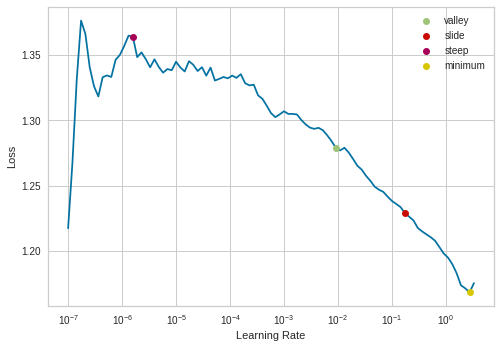

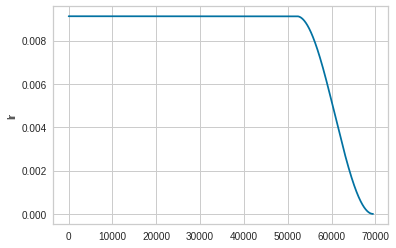

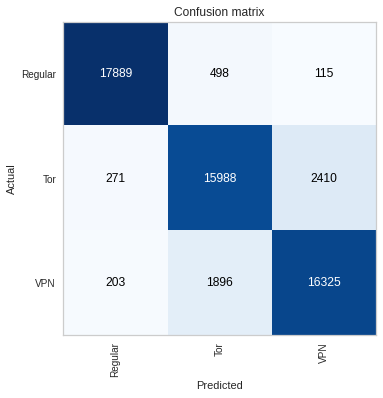

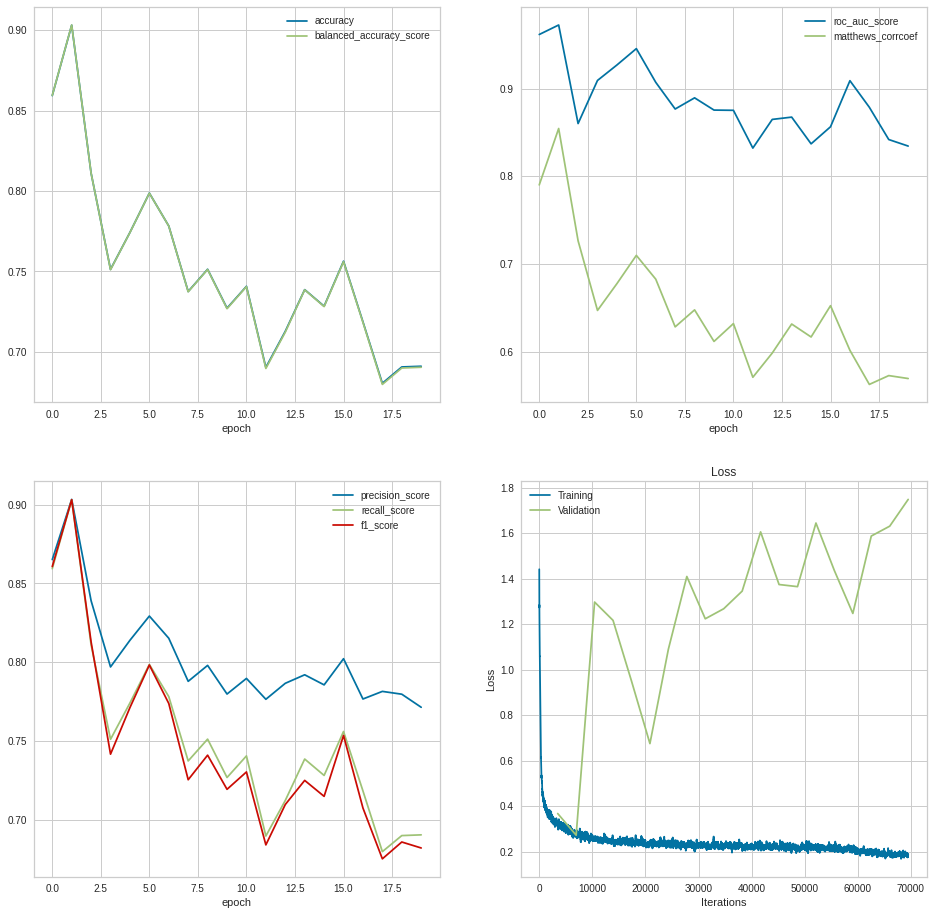

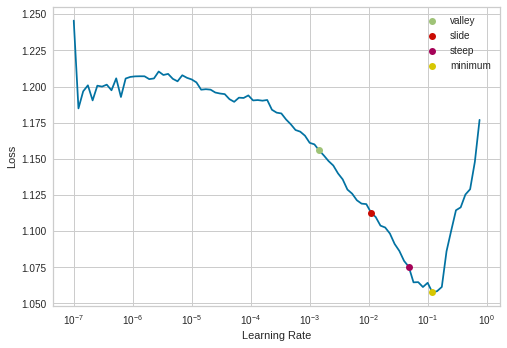

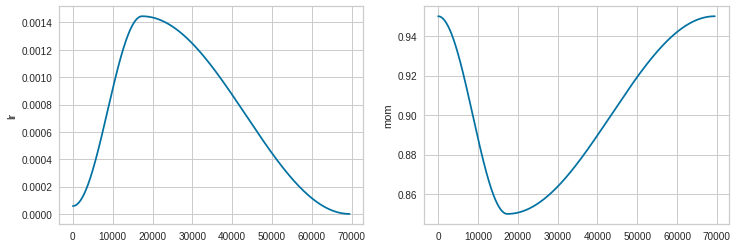

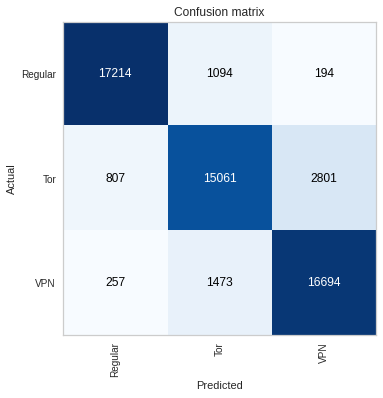

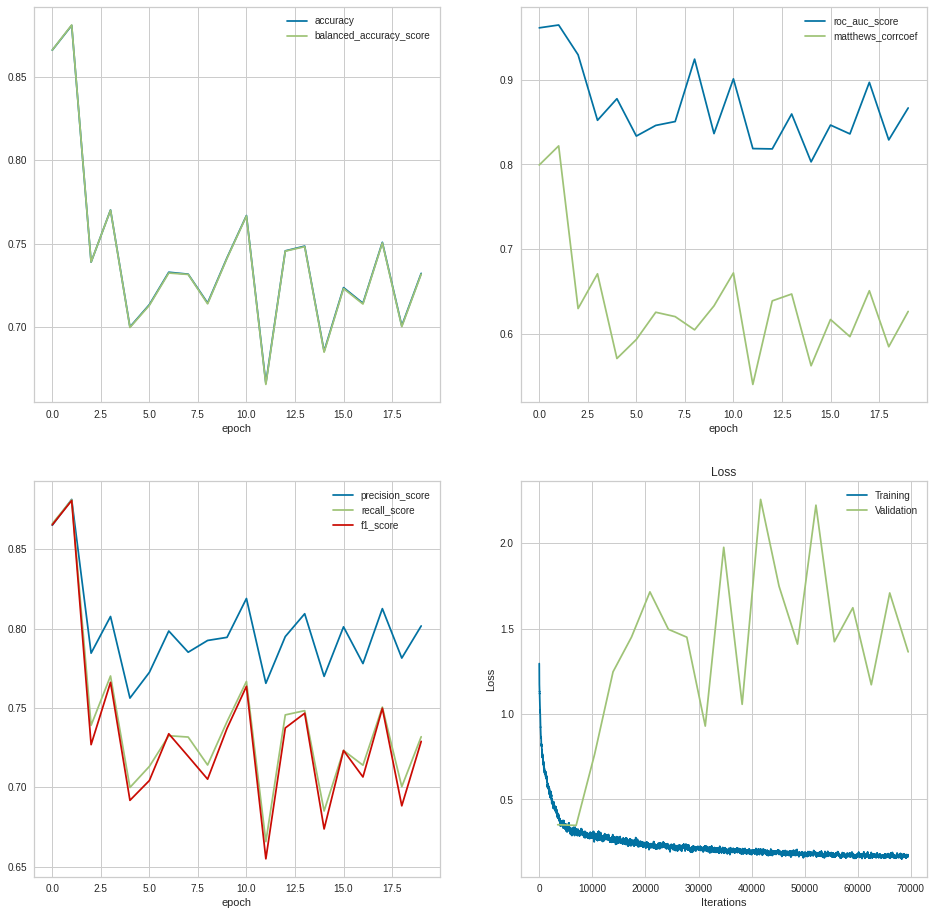

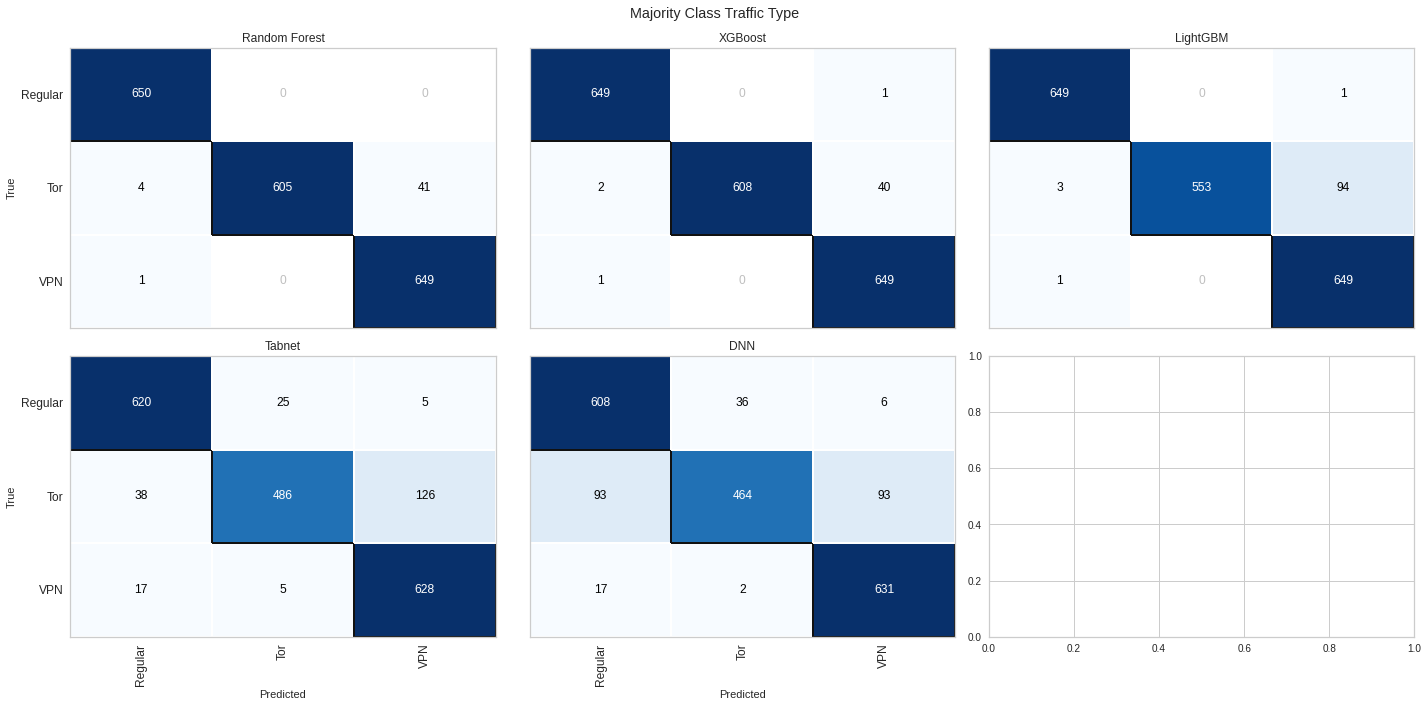

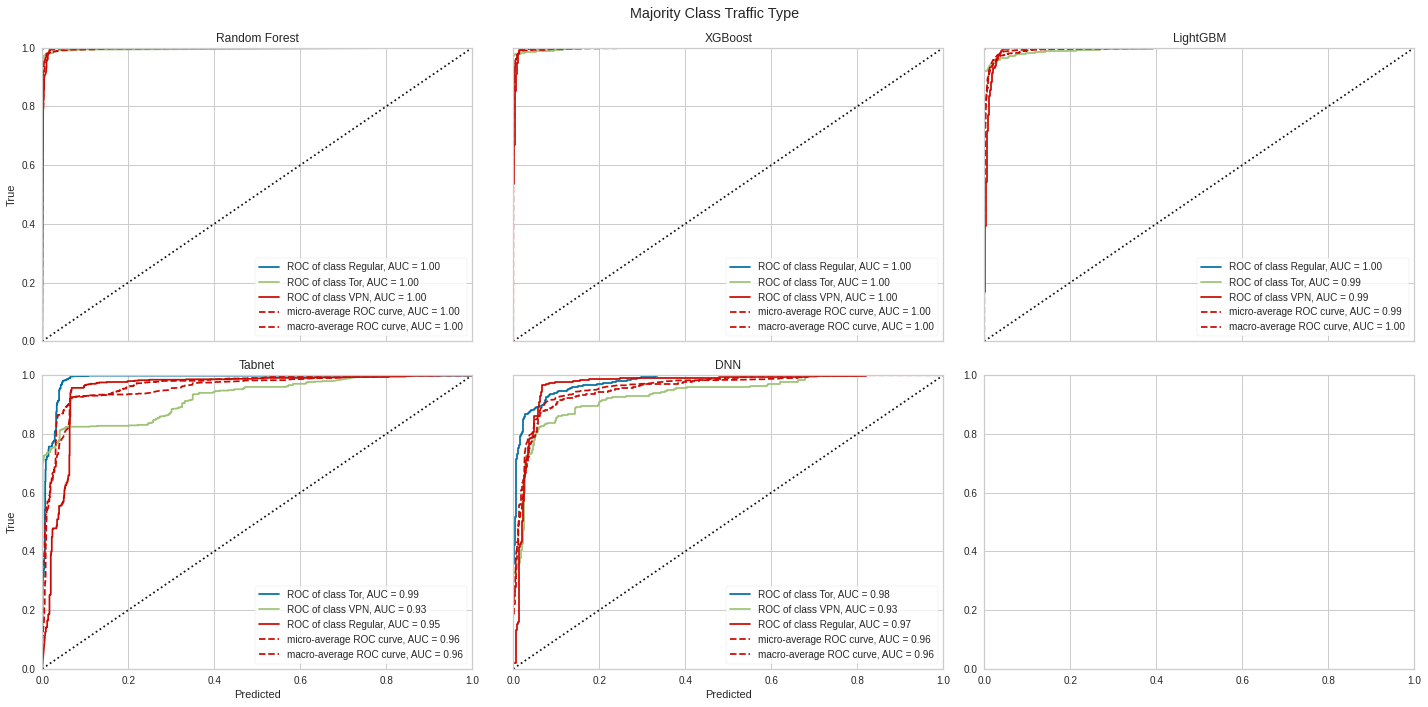

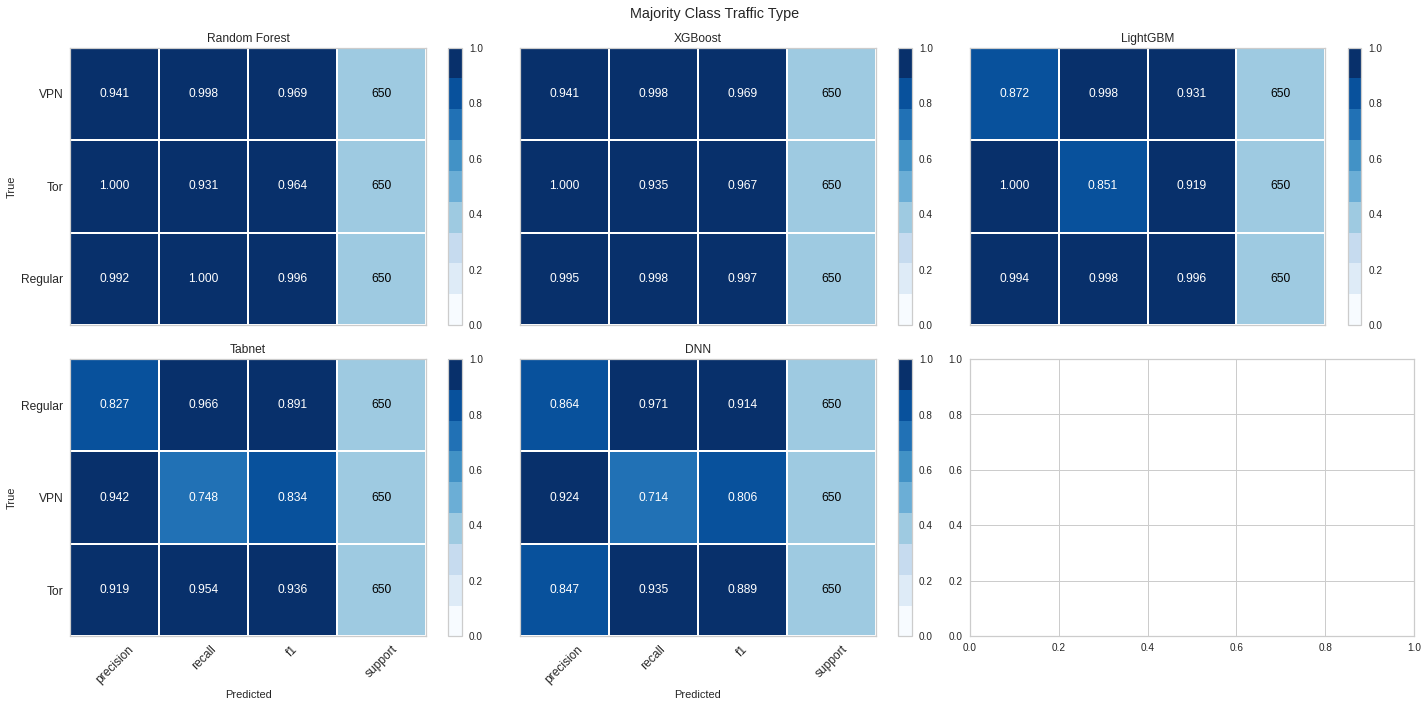

In [13]:
logger_1 = utils.DFLogger()
collector_1 = utils.ModelStatsCallback()
grapher_1 = utils.LazyGraphCallback()
model_saver_1 = utils.SaveModelCallback(monitor='f1_score')
callbacks_1 = [logger_1, grapher_1, model_saver_1, collector_1]

logger_2 = utils.DFLogger()
collector_2 = utils.ModelStatsCallback()
grapher_2 = utils.LazyGraphCallback()
model_saver_2 = utils.SaveModelCallback(monitor='f1_score')
callbacks_2 = [logger_2, grapher_2, model_saver_2, collector_2]


boost_param_grid = {
        "classifier__n_estimators": [100],
        'classifier__max_depth': [2,6,12],
        'classifier__min_child_weight': [4,10],
        "classifier__eval_metric": ["mlogloss"]
}
rf_param_grid = {
        'classifier__n_estimators': [100, 500],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
}


classifiers = [ utils.RandomForestClassifier(), utils.XGBClassifier(),  utils.LGBMClassifier(),
               "utils.run_tabnet_experiment(gan_balanced_traffic_majority['Dataset'], 'Tabnet', 'Traffic Type', epochs=20, callbacks=callbacks_1, no_bar=True)",
               "utils.run_deep_nn_experiment(gan_balanced_traffic_majority['Dataset'], 'Deep Neural Network', 'Traffic Type', list(125 for i in range(15)), epochs=20, callbacks=callbacks_2, no_bar=True)"
               ]


classifier_names = ["Random Forest", "XGBoost", "LightGBM",  "Tabnet", "DNN"]
shallow_classifiers = ["Random Forest", "XGBoost", "LightGBM"]
param_grids = [ rf_param_grid, boost_param_grid, boost_param_grid ]
traffic_equal_result = train_and_evaluate_n_classifiers(gan_balanced_traffic_majority['Dataset'], classifiers, "Traffic Type", classifier_names, shallow_classifiers,"Majority Class Traffic Type", param_grids, baseline_traffic_test['Dataset'], [callbacks_1, callbacks_2])

### 30,000 Regular, 20,000 VPN, and 10,000 Tor

Results for Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6072
           1       1.00      1.00      1.00      1946
           2       1.00      1.00      1.00      3982

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000

	Accuracy: 0.998

	F1: 0.9979999920900581

	AUC: 0.9995281023052366

	Mathew's Correlation: 0.996707667999307

[22:08:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Results for XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6072
           1       1.00      1.00      1.00      1946
           2       1.00      1.00      1.00   

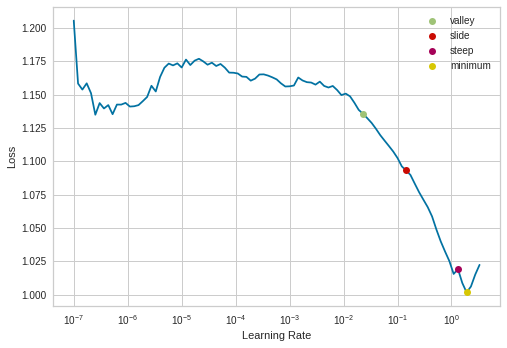

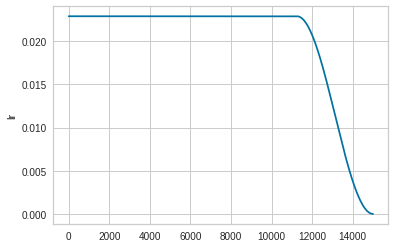

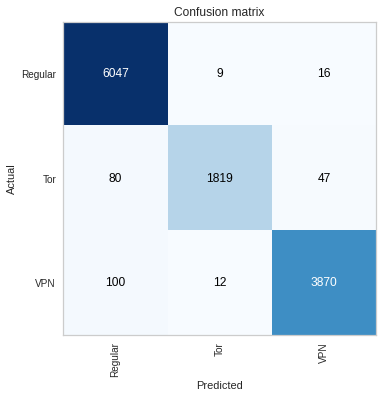

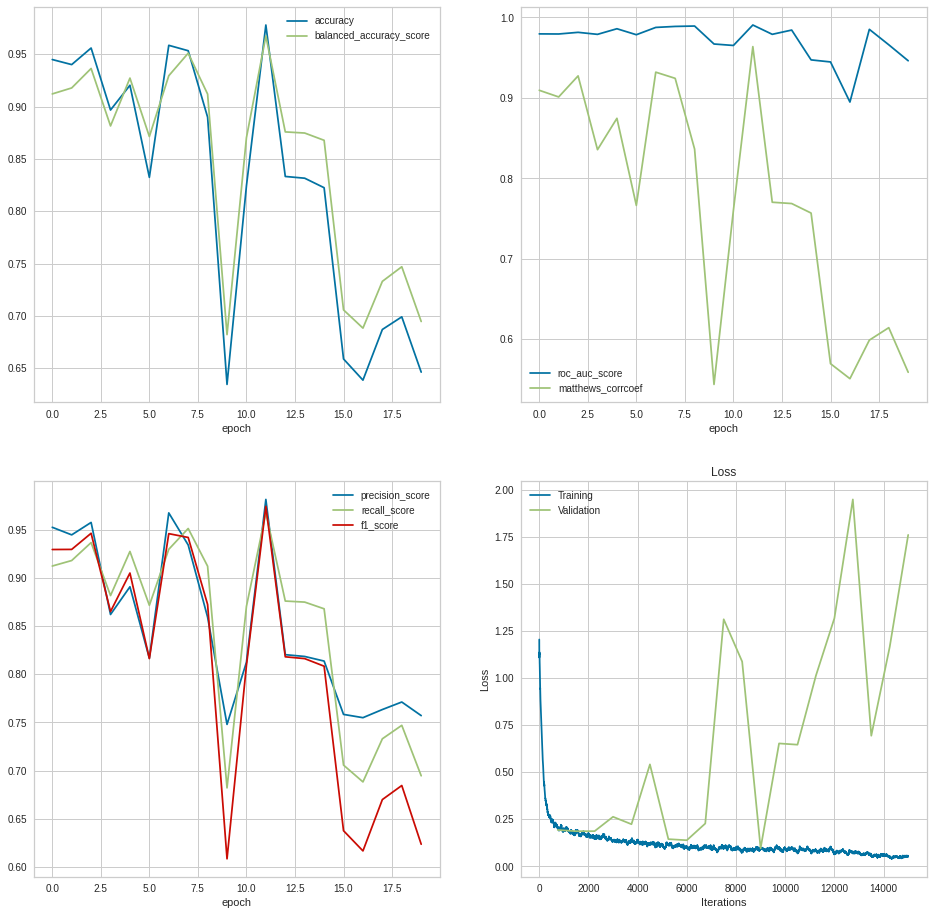

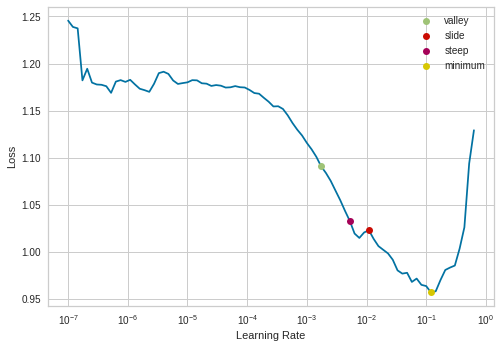

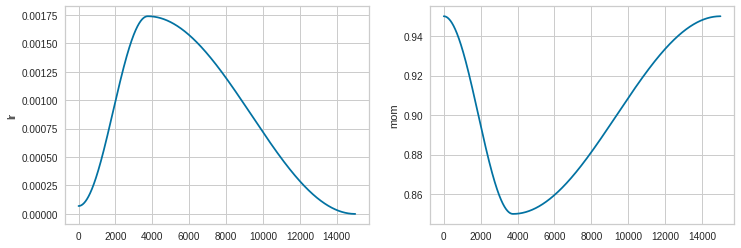

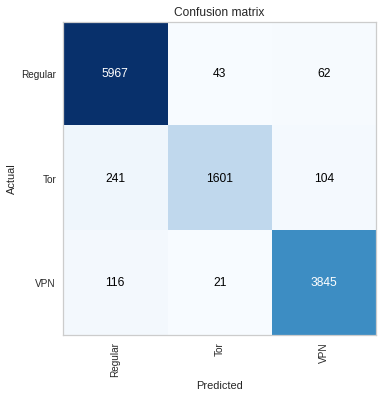

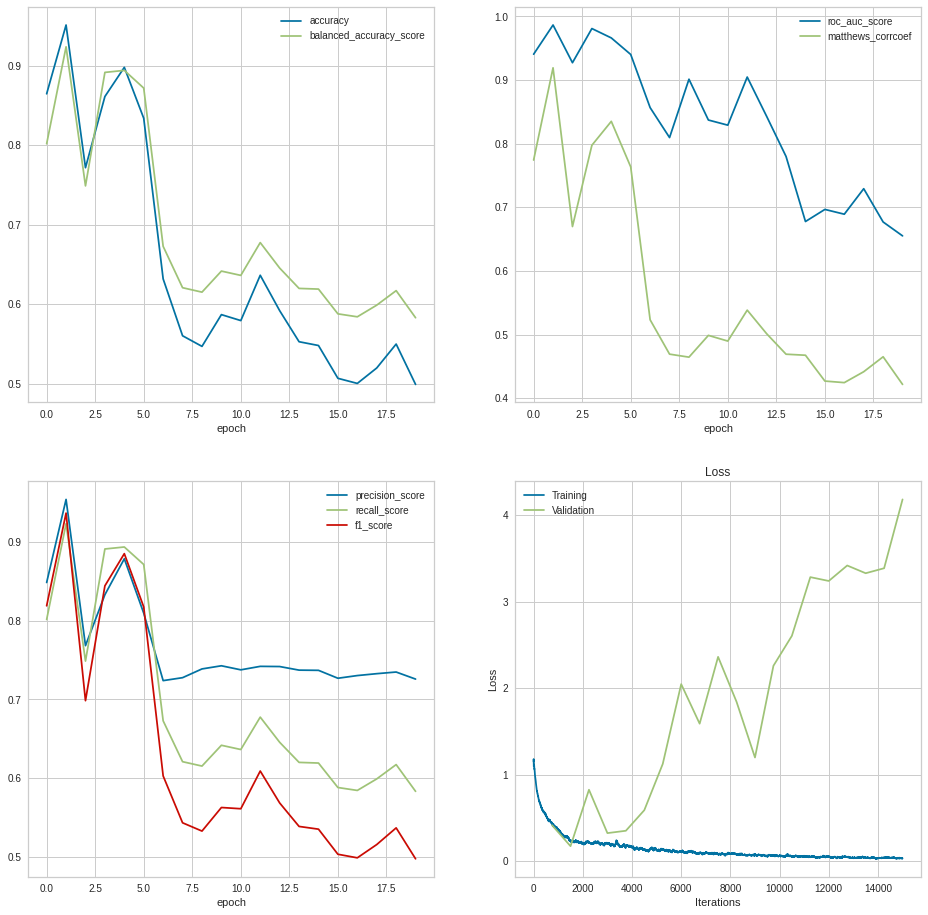

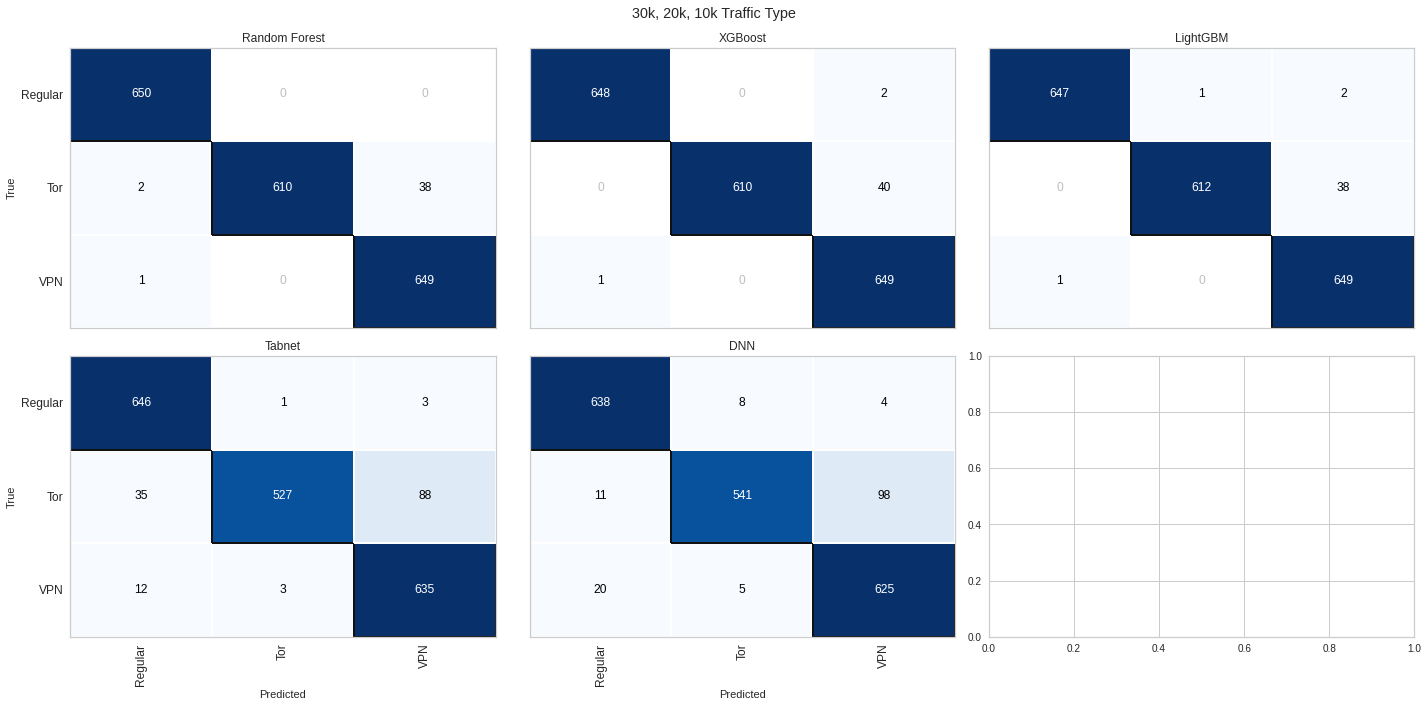

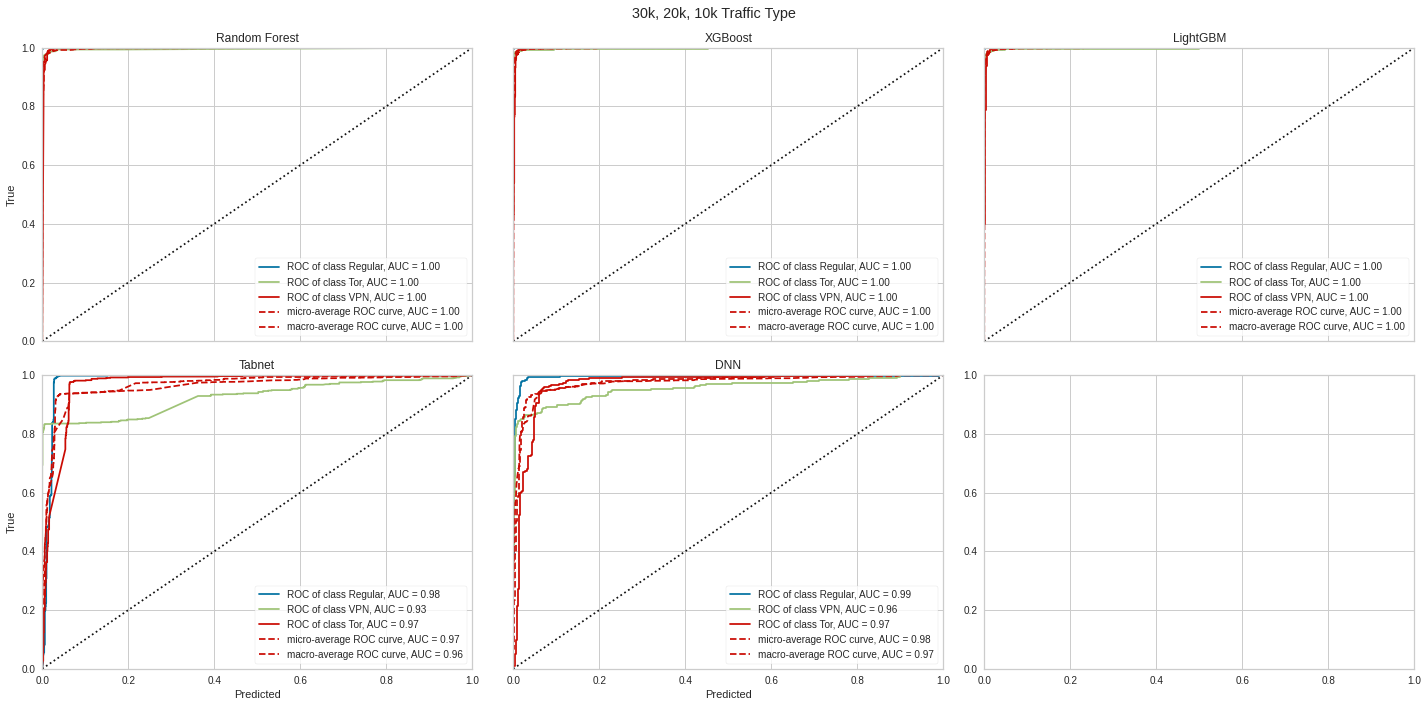

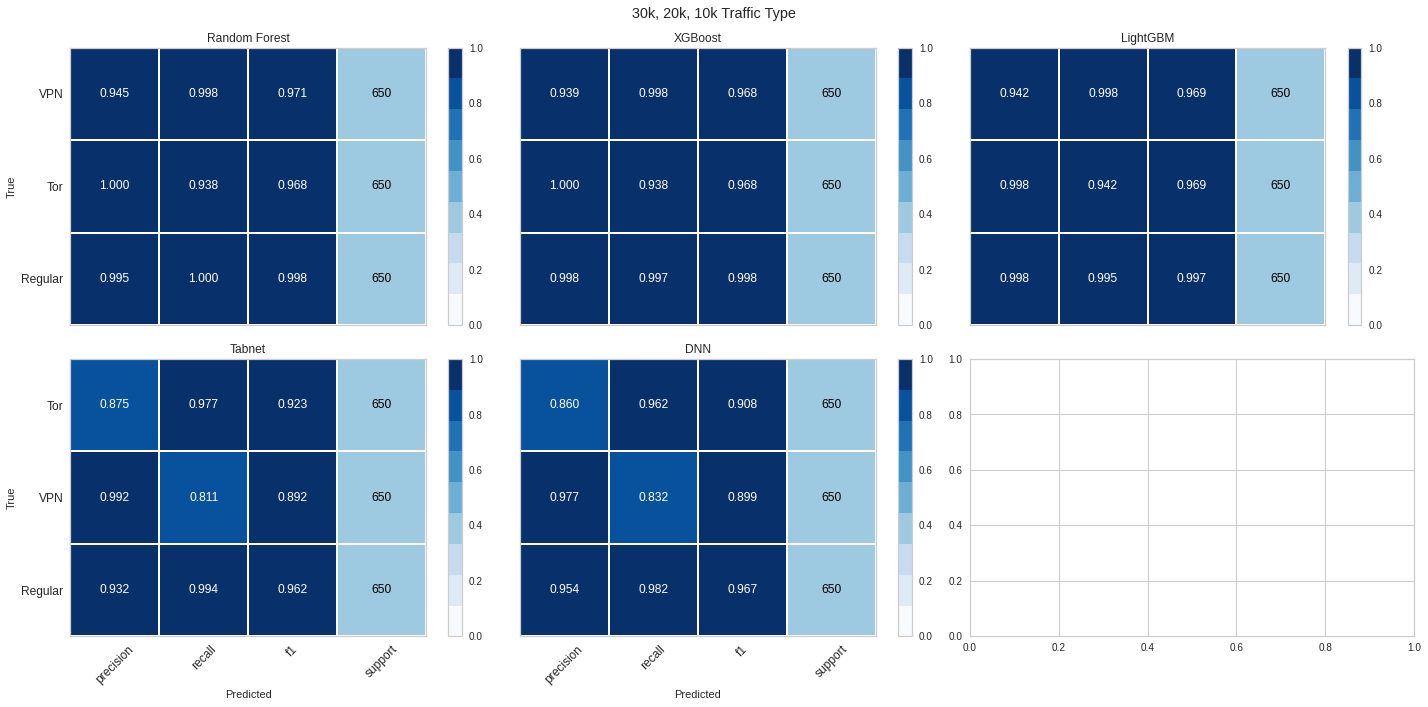

In [12]:
logger_1 = utils.DFLogger()
collector_1 = utils.ModelStatsCallback()
grapher_1 = utils.LazyGraphCallback()
model_saver_1 = utils.SaveModelCallback(monitor='f1_score')
callbacks_1 = [logger_1, grapher_1, model_saver_1, collector_1]

logger_2 = utils.DFLogger()
collector_2 = utils.ModelStatsCallback()
grapher_2 = utils.LazyGraphCallback()
model_saver_2 = utils.SaveModelCallback(monitor='f1_score')
callbacks_2 = [logger_2, grapher_2, model_saver_2, collector_2]


classifiers = [ utils.RandomForestClassifier(), utils.XGBClassifier(),  utils.LGBMClassifier(),
               "utils.run_tabnet_experiment(gan_balanced_traffic_30_20_10['Dataset'], 'Tabnet', 'Traffic Type', epochs=20, callbacks=callbacks_1, no_bar=True)",
                "utils.run_deep_nn_experiment(gan_balanced_traffic_30_20_10['Dataset'], 'Deep Neural Network', 'Traffic Type', list(125 for i in range(15)), epochs=20, callbacks=callbacks_2, no_bar=True)"
               ]

proportional_results = train_and_evaluate_n_classifiers(gan_balanced_traffic_30_20_10['Dataset'], classifiers, "Traffic Type", classifier_names, shallow_classifiers,"30k, 20k, 10k Traffic Type", param_grids, baseline_traffic_test['Dataset'], [callbacks_1, callbacks_2])


# Application Type Classification

### Majority Class

In [ ]:
logger_1 = utils.DFLogger()
collector_1 = utils.ModelStatsCallback()
grapher_1 = utils.LazyGraphCallback()
model_saver_1 = utils.SaveModelCallback(monitor='f1_score')
callbacks_1 = [logger_1, grapher_1, model_saver_1, collector_1]

logger_2 = utils.DFLogger()
collector_2 = utils.ModelStatsCallback()
grapher_2 = utils.LazyGraphCallback()
model_saver_2 = utils.SaveModelCallback(monitor='f1_score')
callbacks_2 = [logger_2, grapher_2, model_saver_2, collector_2]

boost_param_grid = {
        "classifier__n_estimators": [100],
        'classifier__max_depth': [2,6,12],
        'classifier__min_child_weight': [4,10],
        "classifier__eval_metric": ["mlogloss"]
}
rf_param_grid = {
        'classifier__n_estimators': [100, 500],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
}


classifiers = [ utils.RandomForestClassifier(), utils.XGBClassifier(),  utils.LGBMClassifier(),
               "utils.run_tabnet_experiment(gan_balanced_application_majority['Dataset'], 'Tabnet', 'Application Type', epochs=20, callbacks=callbacks_1, no_bar=True)",
                "utils.run_deep_nn_experiment(gan_balanced_application_majority['Dataset'], 'Deep Neural Network', 'Application Type', list(125 for i in range(15)), epochs=20, callbacks=callbacks_2, no_bar=True)"
               ]

classifier_names = ["Random Forest", "XGBoost", "LightGBM",  "Tabnet", "DNN"]
shallow_classifiers = ["Random Forest", "XGBoost", "LightGBM"]
param_grids = [ rf_param_grid, boost_param_grid, boost_param_grid ]

majority_class_application_results = train_and_evaluate_n_classifiers(gan_balanced_application_majority['Dataset'], classifiers, "Application Type", classifier_names, shallow_classifiers,"Majority Class Application Type", param_grids, baseline_application_test['Dataset'], [callbacks_1, callbacks_2])

KeyboardInterrupt: 

### 30,000 Each Type

In [11]:
logger_1 = utils.DFLogger()
collector_1 = utils.ModelStatsCallback()
grapher_1 = utils.LazyGraphCallback()
model_saver_1 = utils.SaveModelCallback(monitor='f1_score')
callbacks_1 = [logger_1, grapher_1, model_saver_1, collector_1]

logger_2 = utils.DFLogger()
collector_2 = utils.ModelStatsCallback()
grapher_2 = utils.LazyGraphCallback()
model_saver_2 = utils.SaveModelCallback(monitor='f1_score')
callbacks_2 = [logger_2, grapher_2, model_saver_2, collector_2]

boost_param_grid = {
        "classifier__n_estimators": [100],
        'classifier__max_depth': [2,6,12],
        'classifier__min_child_weight': [4,10],
        "classifier__eval_metric": ["mlogloss"]
}
rf_param_grid = {
        'classifier__n_estimators': [100, 500],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
}


classifiers = [ utils.RandomForestClassifier(), utils.XGBClassifier(),  utils.LGBMClassifier(),
               "utils.run_tabnet_experiment(gan_balanced_application_30_30_30['Dataset'], 'Tabnet', 'Application Type', epochs=20, callbacks=callbacks_1, no_bar=True)",
                "utils.run_deep_nn_experiment(gan_balanced_application_30_30_30['Dataset'], 'Deep Neural Network', 'Application Type', list(125 for i in range(15)), epochs=20, callbacks=callbacks_2, no_bar=True)"
               ]

equal_application_results = train_and_evaluate_n_classifiers(gan_balanced_application_30_30_30['Dataset'], classifiers, "Application Type", classifier_names, shallow_classifiers,"30,000 Application Type", param_grids, baseline_application_test['Dataset'], [callbacks_1, callbacks_2])

Results for Random Forest
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      5982
           1       0.88      0.95      0.91      5979
           2       0.57      0.57      0.57      5954
           3       0.55      0.64      0.59      6079
           4       0.61      0.50      0.55      5984
           5       0.97      0.95      0.96      6017
           6       0.62      0.52      0.57      6064
           7       0.53      0.68      0.60      5941

    accuracy                           0.69     48000
   macro avg       0.70      0.69      0.69     48000
weighted avg       0.70      0.69      0.69     48000

	Accuracy: 0.691125

	F1: 0.6912462606026214

	AUC: 0.9380866969475183

	Mathew's Correlation: 0.6481334228183016

[06:05:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metri

In [ ]:
print(f'Last Execution: {utils.datetime.datetime.now()}')
assert False, 'Nothing after this point is included in the study'